In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

![title](logo-utn.png)

## *Fundamentos de la Robótica Móvil.*
### Trabajo Practico N° 3: Mediciones de sensor de barrido láser

---

### Autor 
* Sanchez Marengo, Nahuel

### Objetivo

Analizar mediciones de un sensor de barrido láser y la relación entre los sistemas de coordenadas del
sensor/robot y del entorno, utilizando para ello el simulador Gazebo.

---

### Adquisición de datos

Para este trabajo práctico, la adquisición de datos de odometría y de sensor de barrido láser, es obtenida a través del simulador Gazebo, corriendo el modelo del robot RoMAA. La teleoperación del robot, fue realizada con un joystick a través del paquete ROS [joystick_drivers](http://wiki.ros.org/joystick_drivers).

Las mediciones, se realizaron en el siguiente entorno:

![title](simulacion.png)

Una vez obtenidas las mediciones, las mismas se almacenan en un archivo de formato .bag, el cual debe ser convertido a .txt para su posterior procesamiento a través de las diversas librerías en Python. Esto se realiza a través del paquete ROS [rosbag2txt](https://github.com/ciiiutnfrc/rosbag2txt.git).

El modelo de sensor láser utilizado, cuenta con las siguentes características:





* Ángulo de medición $\zeta_{min} = -(3/4)\pi$ y $\zeta_{max} = (3/4)\pi$ 
* Rango de medición: $\rho_{min} = 0.10m$ y $\rho_{max} = 10m$
* Cantidad de haces: $N_l=540$

### Procesamiento y visualización de datos

En primera instancia, se cargan las mediciones en variables de tipo Pandas Dataframe. 

En `df_odom` se almacena la pose del robot y su velocidades lineal y angular instantáneas, además del timestamp de cada medición:

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import math

# Carga de datos de odometría
df_odom = pd.read_csv('odom.txt', header = None, delim_whitespace=True )
df_odom.columns = ['tiempo', 'posX', 'posY', 'ang', 'vLin', 'vAng']

# Carga de datos del scanner
df_scan = pd.read_csv('scan.txt', header = None, delim_whitespace=True )
df_scan.rename(columns = {0:'tiempo'}, inplace = True)

# Lleva tiempos iniciales a 0
t_inicial = min((df_scan['tiempo'][0], df_odom['tiempo'][0]))
df_scan['tiempo'] = df_scan['tiempo'] - t_inicial
df_odom['tiempo'] = df_odom['tiempo'] - t_inicial

df_odom

tiempo     posX     posY      ang     vLin     vAng
0       0.00 -0.09858  0.00952 -0.12606  0.00009  0.00082
1       0.04 -0.09859  0.00952 -0.12606 -0.00041 -0.00084
2       0.08 -0.09861  0.00952 -0.12608 -0.00076 -0.00116
3       0.12 -0.09862  0.00952 -0.12608  0.00023  0.00120
4       0.16 -0.09863  0.00952 -0.12609 -0.00093 -0.00125
...      ...      ...      ...      ...      ...      ...
2094   83.76  0.20574 -5.35272 -1.79379 -0.00076 -0.00166
2095   83.80  0.20574 -5.35271 -1.79381 -0.00015  0.00033
2096   83.84  0.20574 -5.35270 -1.79382 -0.00015 -0.00055
2097   83.88  0.20574 -5.35268 -1.79385 -0.00066 -0.00162
2098   83.92  0.20575 -5.35267 -1.79386 -0.00004  0.00093

[2099 rows x 6 columns]

A partir de la lectura del dataset, se corrobora que las mediciones de odometría son enviadas a una frecuencia $f_O$ de 25 veces por segundo:

In [5]:
T_odom = df_odom['tiempo'][1]-df_odom['tiempo'][0]
f_odom = 1/T_odom
print('T_o = {:.3f}s' .format(T_odom))
print('f_o = {:.3f}Hz' .format(f_odom))

T_o = 0.040s
f_o = 25.000Hz


Por su parte, por cada barrido se almacena en `df_scan`, un vector los valores de rango y su respectivo timestamp:

In [6]:
df_scan

tiempo        1        2        3        4        5        6        7  \
0     0.061  3.67110  3.68989  3.70354  3.71856  3.72451  3.73738  3.74525   
1     0.161  3.66938  3.66233  3.69901  3.72831  3.71670  3.74406  3.75858   
2     0.261  3.67786  3.69019  3.69637  3.72440  3.70802  3.74111  3.76339   
3     0.361  3.67377  3.67812  3.70064  3.71120  3.73191  3.73526  3.77372   
4     0.461  3.68562  3.67971  3.70589  3.71321  3.72602  3.74391  3.76001   
..      ...      ...      ...      ...      ...      ...      ...      ...   
834  83.480      inf      inf      inf      inf      inf      inf      inf   
835  83.580      inf      inf      inf      inf      inf      inf      inf   
836  83.680      inf      inf      inf      inf      inf      inf      inf   
837  83.780      inf      inf      inf      inf      inf      inf      inf   
838  83.880      inf      inf      inf      inf      inf      inf      inf   

           8        9  ...      531      532      533      534      535  \
0    3.79328  3.78623  ...  8.40000  8.29664  8.25813  8.23274  8.24487   
1    3.80144  3.79685  ...  8.39892  8.30290  8.28757  8.23913  8.24474   
2    3.78013  3.79676  ...  8.39065  8.30937  8.26338  8.24737  8.23804   
3    3.78482  3.81701  ...  8.41627  8.30968  8.27421  8.25111  8.25906   
4    3.77116  3.81403  ...  8.39394  8.31246  8.25868  8.24632  8.24922   
..       ...      ...  ...      ...      ...      ...      ...      ...   
834      inf      inf  ...      inf      inf      inf      inf      inf   
835      inf      inf  ...      inf      inf      inf      inf      inf   
836      inf      inf  ...      inf      inf      inf      inf      inf   
837      inf      inf  ...      inf      inf      inf      inf      inf   
838      inf      inf  ...      inf      inf      inf      inf      inf   

         536      537      538      539      540  
0    8.26126  8.31087  8.38720      inf      inf  
1    8.24719  8.29611  8.40132      inf      inf  
2    8.27471  8.29858  8.37852      inf      inf  
3    8.26695  8.30974  8.38677      inf      inf  
4    8.25426  8.33162  8.38244      inf      inf  
..       ...      ...      ...      ...      ...  
834      inf  7.94490  7.85308  7.80002  7.77279  
835      inf  7.93608  7.85601  7.81394  7.78490  
836      inf  7.95376  7.85370  7.79932  7.77582  
837      inf  7.94941  7.83070  7.80186  7.78295  
838      inf  7.94999  7.83286  7.81095  7.78727  

[839 rows x 541 columns]

Del mismo modo, se comprueba que las mediciones de cada barrido láser son enviadas a una frecuencia $f_L$ de 10 veces por segundo:

In [7]:
T_scan = df_scan['tiempo'][1]-df_scan['tiempo'][0]
f_scan = 1/T_scan
print('T_L= {:.3f}s' .format(T_scan))
print('f_L = {:.3f}Hz' .format(f_scan))

T_L= 0.100s
f_L = 10.000Hz


Como el ángulo para el cual se realiza cada una de las 540 mediciones está implícito en su posición dentro del vector, es necesario generar un vector de ángulos para poder graficar estos datos sobre un diagrama polar.

In [8]:
start = -3/4*np.pi
stop = 3/4*np.pi
step = 3/2*np.pi/540

ang_medicion = np.arange(start, stop, step)

En la Figura 1 se grafican los valores devueltos por el sensor láser, para 3 instantes de tiempo $t_1$, $t_2$ y $t_3$

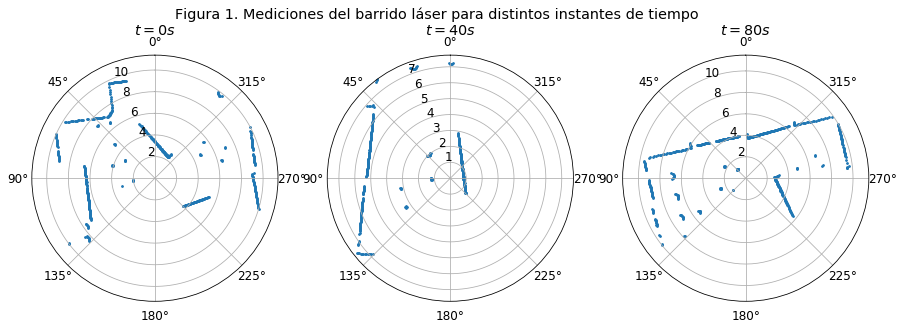

In [9]:
TS = [0, 40, 80] # valores de timestamp a graficar [seg]

fig, ax = plt.subplots(1, len(TS), subplot_kw={'projection': 'polar'},);
fig.set_size_inches(15, 5)
fig.suptitle('Figura 1. Mediciones del barrido láser para distintos instantes de tiempo')

for i, ts in enumerate(TS):
    index = pd.Index(df_scan['tiempo']).get_indexer([ts], method='nearest')
    ax[i].scatter(ang_medicion, df_scan.iloc[index,1:], s=3)
    ax[i].set_theta_offset(np.pi / 2.0)
    ax[i].set_title('$t = {} s$'.format(ts), va='bottom')


Si bien los datos del sensor de barrido láser, nos dan una idea de la topología del entorno, puede que no resulten suficientes a la hora de realizar un mapeo completo. Esto se debe a que sus mediciones solo están referidas al sistemas de coordenadas del propio láser $L$.

Como se tienen disponibles los datos de odometría, es posible combinar las mediciones láser con estos últimos y de obtener un mapeo del entorno referido al marco de referencia global $G$.

El primer problema que aparece al intentar combinar los datos de odometría con los datos del barrido láser, es que tanto su frecuencia de captura como sus timestamps no coinciden. Como $f_O>f_L$, es necesario filtrar los datos de odometría, para quedarse solo con aquel cuyo timestamp sea el más cercano al timestamp de medición láser. Esto se realiza con el método `.get_indexer` pasándole el parámetro `method='nearest'`

In [10]:
t_odom = df_odom['tiempo']
t_scan = df_scan['tiempo']

indexes = pd.Index(t_odom).get_indexer(t_scan, method='nearest')
df_odom_filtered = df_odom.iloc[indexes].reset_index(drop=True)  #dataframe odometría filtrado
t_odom_f = df_odom_filtered['tiempo']

En la Figura 2, se muestran gráficamente, las mediciónes de odometría seleccionadas para cada medición del sensor láser.

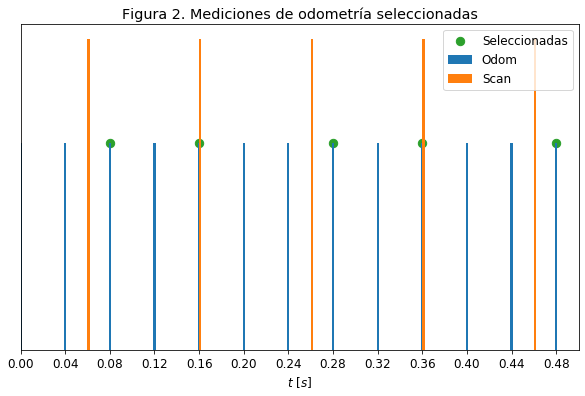

In [11]:
periodo = 0.5  #período de tiempo a graficar en segundos

plt.subplots(figsize=(10, 6));
plt.bar(t_odom[t_odom < t_odom[0]+periodo],                             # mediciones odometría
        np.ones(len(t_odom[t_odom < periodo]))*1,
        width=0.002, align='center', label='Odom')

plt.bar(t_scan[t_scan < t_scan[0]+periodo],                             # mediciones laser
        np.ones(len(t_scan[t_scan < periodo]))*1.5,
        width=0.002,align='center', label='Scan')

plt.scatter(df_odom_filtered['tiempo'][t_odom_f < t_odom_f[0]+periodo], # mediciones seleccionadas
            np.ones(len(df_odom_filtered['tiempo'][t_odom_f < t_odom_f[0]+periodo]))*1, s=70, 
            label='Seleccionadas')

plt.title('Figura 2. Mediciones de odometría seleccionadas')
plt.legend(loc=1)
plt.xlim((0, periodo))
plt.xticks(t_odom[t_odom < t_odom[0]+periodo])
plt.yticks([])
plt.xlabel('$t$ [$s$]')
plt.show()


Como es de esperar, al seleccionar la medición de odometría más cercana, se cometerá un error comprendido entre $\pm T_O /2$. En la Figura 3 se grafica el histograma de este error.

Este efecto podría ser minimizado estimando el estado intermedio entre las dos mediciones de odometría más cercanas, teniendo en cuentas las mediciones de velocidad linear y angular.

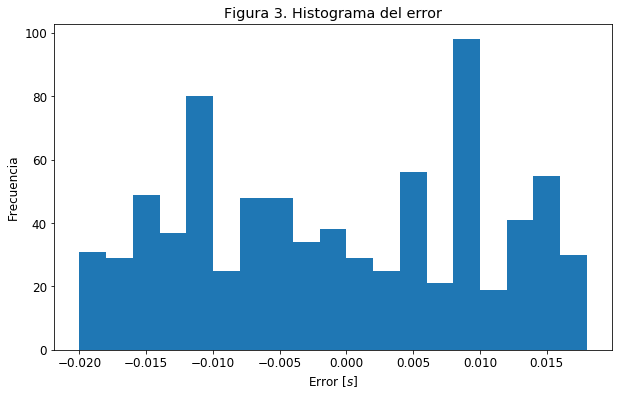

In [124]:
error = df_scan['tiempo'] - df_odom_filtered['tiempo']
plt.subplots(figsize=(10, 6));
plt.title('Figura 3. Histograma del error')
plt.hist(error, np.arange(-0.02, 0.02, 0.002))
plt.xlabel('Error [$s$]')
plt.ylabel('Frecuencia')
plt.show()

Como se mencionó anteriormente, para la construcción del mapa se pretende expresar las mediciones láser en el marco de referencia global $G$. Para ello, es necesario obtener la matriz de transformación $^{\!L}_{G}T$. Se debe tener en cuenta que el marco de referencia del láser, solo está desplazado en $z$ respecto del marco de referencia $R$ del robot, mientras que sigue alineado en $x$ e $y$.

$$
^{\!L}_{G}T = \begin{bmatrix}
                                    ^{\!L}_{G}A & ^{\!L}\mathbf{p}\\
                                    0 & 1
                                    \end{bmatrix}
$$

Donde $^{\!L}_{\mathcal{O}}A$ es la matriz de rotación y $^{\!L}\mathbf{p}$ es la traslación. 



$$
^{\!L}_{\mathcal{G}}A = \begin{bmatrix}
                                      cos(\theta) & -sin(\theta) \\
                                      sin(\theta) & cos(\theta)
                                  \end{bmatrix}
$$

$$
^{\!L}\mathbf{p} = \begin{bmatrix}
                                      x \\
                                      y
                                  \end{bmatrix}
$$


![title](referencias.png)

De la siguiente forma, se obtendrá un punto $^{\!G}p$ a partir de un punto $^{\!L}p$:

$$
^{\!G}p = \: ^{\!L}_{G}A \cdot \: ^{\!L}p + ^{\!L}\mathbf{p}
$$

A continuación, se presenta un script que realiza el mapeo previamente propuesto y genera un vector `Pg` con los puntos mapeados en coordenadas rectangulares.

In [125]:
if 0:
    Pg = np.empty(0)
    for i in range(0, len(df_scan)):
        # se calcula la matriz de rotación
        ang = df_odom_filtered.iloc[i]['ang']
        R_matrix = np.array([[math.cos(ang), -1*math.sin(ang)],
                             [math.sin(ang), math.cos(ang)]])

        # se calcula la matriz de traslación
        T = np.array([[df_odom_filtered.iloc[i]['posX']],
                      [df_odom_filtered.iloc[i]['posY']]])

        # se pasa de coordenadas polares a rectangulares
        xr = df_scan.iloc[i,1:]*np.cos(ang_medicion)
        yr = df_scan.iloc[i,1:]*np.sin(ang_medicion)
        
        for j in range(0, len(ang_medicion)):
            if xr.iloc[j] <= 10 and yr.iloc[j] <= 10:
                Pr = np.array([[xr.iloc[j]],      # punto medición laser en coordenadas del robot
                               [yr.iloc[j]]])
                Proted = np.matmul(R_matrix, Pr)
                Pg_j = np.add(Proted, T)          # punto medición laser en coordenadas globales

                if len(Pg) == 0:
                    Pg = Pg_j
                else:
                    Pg = np.append(Pg, Pg_j, axis=1) # puntos transformados en coord rect glboales 

Sin embargo, se propone una solución alternativa de mayor eficiencia, donde se generan dos vectores `xg` e `yg` con las proyecciones de cada punto de medición en coordenadas globales. Los mismos se grafican junto al camino seguido por el robot en la figura 4.

In [126]:
xg = pd.Series([])
yg = pd.Series([])
for i in range(0, len(df_odom_filtered)):
    ang_medicion_g = ang_medicion + df_odom_filtered.iloc[i]['ang']
    x = df_scan.iloc[i,1:]*np.cos(ang_medicion_g) + df_odom_filtered.iloc[i]['posX']
    y = df_scan.iloc[i,1:]*np.sin(ang_medicion_g) + df_odom_filtered.iloc[i]['posY']
    xg = pd.concat([xg, x], ignore_index=True)
    yg = pd.concat([yg, y], ignore_index=True)
    

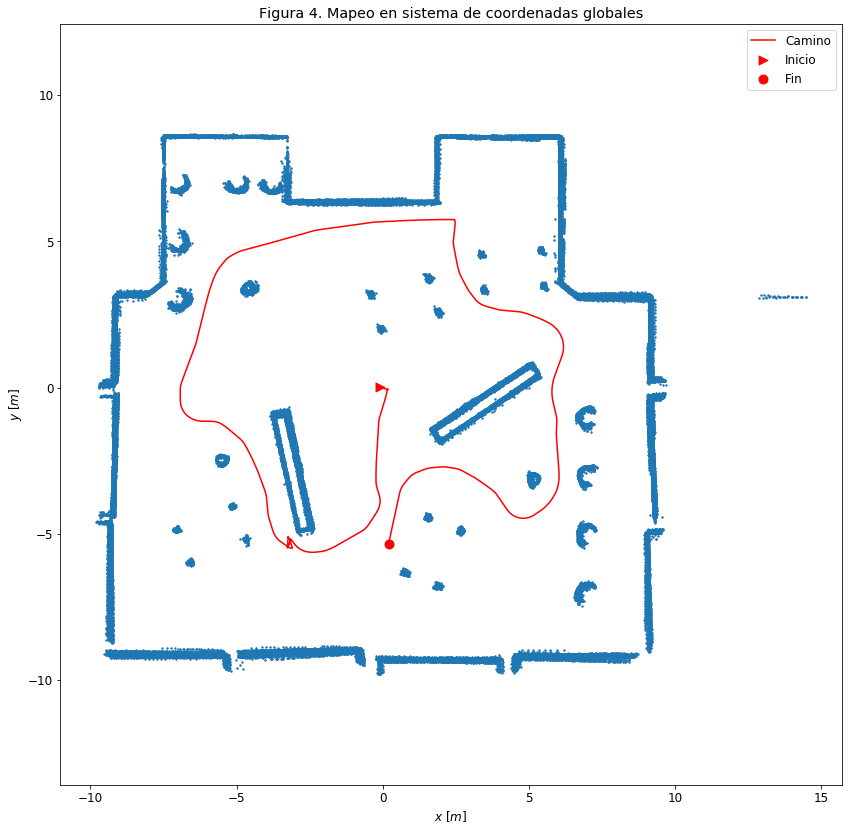

In [132]:
plt.subplots(figsize=(14, 14));
plt.scatter(xg, yg, s=2)
plt.plot(df_odom['posX'], df_odom['posY'], c='red', label='Camino')
plt.scatter(df_odom['posX'].iloc[0], df_odom['posY'].iloc[0], c='red', s=80, marker=">", label='Inicio')
plt.scatter(df_odom['posX'].iloc[-1], df_odom['posY'].iloc[-1], c='red', s=80, label='Fin')   
plt.axis('equal')
plt.legend()
plt.xlabel('$x$ [$m$]')
plt.ylabel('$y$ [$m$]')
plt.title('Figura 4. Mapeo en sistema de coordenadas globales')
plt.show()

En la Figura 5, Realizando un zoom de un sector del mapa obtenido, se puede ver el efecto de la sumatorias de errores del sistema:

* Errores aleatorios del sensor de barrido láser
* Errores aleatorios de los sensores de odometría
* Error sistemático en la selección de mediciones



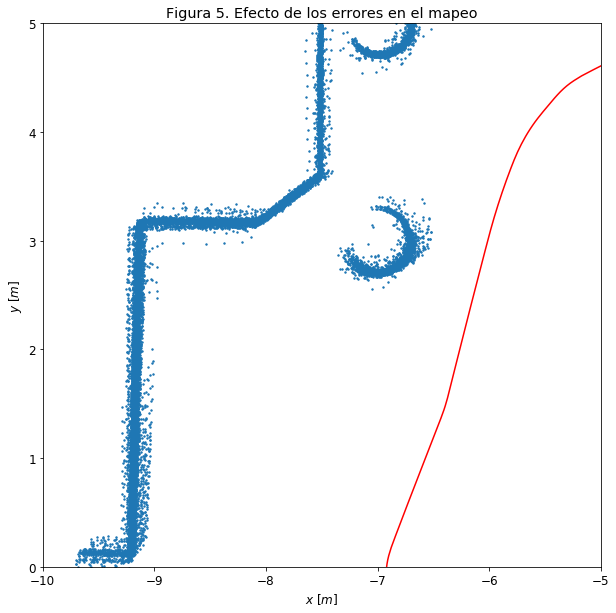

In [128]:
plt.subplots(figsize=(10, 10));
plt.scatter(xg, yg, s=2)
plt.plot(df_odom['posX'], df_odom['posY'], c='red')
plt.scatter(df_odom['posX'][0], df_odom['posY'][0], c='red')
plt.xlim((-10,-5))
plt.ylim((0,5))
plt.xlabel('$x$ [$m$]')
plt.ylabel('$y$ [$m$]')
plt.title('Figura 5. Efecto de los errores en el mapeo')

plt.show()

### Conclusiones

En primer lugar, se hizo visible el problema de combinar mediciones no simultáneas, resultado en la introducción de un error sistemático. Este efecto, se pudo ver en el mapeo final realizado sumado a las otras fuentes de ruido aleatorias. De este análisis se desprende que la realización de barridos redundantes, no implican una mayor precisión del mapeo, ya que estará limitada por los efectos del ruido y se le sumarán el error sistemático previamente mencionado.

Se encuentra una gran limitación en el mapa realizado que es que éste no muestra los lugares inexplorados, ya que pondera de la misma forma un lugar vacío que un lugar desconocido. Este error se comete debido a la forma en que el mismo se construyó. Una opción de mayor utilidad sería construir una grilla de ocupación donde se muestre la probabilidad de ocupación de cada punto.
